## Create a simple forecast from the NDFD which can be used with NWS graphics

In [1]:
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from pyproj import Proj
import pandas as pd
import pytz
from PIL import Image

### Get current time rounded down to last 30 minute interval

In [2]:
def rounded_to_the_last_30_minute():
    now = datetime.now()
    rounded = now - (now - datetime.min) % timedelta(minutes=30)
    return rounded

In [3]:
date = rounded_to_the_last_30_minute()

### Import NDFD data for latest time

In [4]:
YYYYMMDD_HHMM = date.strftime('%Y%m%d_%H%M')
YYYYMMDD_HHMM

'20231211_1830'

In [5]:
File = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NDFD/NWS/CONUS/CONDUIT/NDFD_NWS_CONUS_conduit_2p5km_"+YYYYMMDD_HHMM+".grib2"
File

'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NDFD/NWS/CONUS/CONDUIT/NDFD_NWS_CONUS_conduit_2p5km_20231211_1830.grib2'

In [6]:
ds = xr.open_dataset(File)

### Parse for data map projection and add lats & lons

In [7]:
ds = ds.metpy.parse_cf()
ds = ds.metpy.assign_latitude_longitude(force=False)
ds

<xarray.Dataset>
Dimensions:                                                                   (
                                                                               time: 3,
                                                                               time_bounds_1: 2,
                                                                               time1: 11,
                                                                               time1_bounds_1: 2,
                                                                               time2: 5,
                                                                               ...
                                                                               time3_bounds_1: 2,
                                                                               x: 2145,
                                                                               y: 1377,
                                                                               time4: 42,
                                                                               height_above_ground1: 1,
                                                                               height_above_ground: 1)
Coordinates: (12/13)
    reftime                                                                   datetime64[ns] ...
  * time                                                                      (time) datetime64[ns] ...
  * time1                                                                     (time1) datetime64[ns] ...
  * time2                                                                     (time2) datetime64[ns] ...
  * time3                                                                     (time3) datetime64[ns] ...
  * x                                                                         (x) float32 ...
    ...                                                                        ...
  * time4                                                                     (time4) datetime64[ns] ...
  * height_above_ground1                                                      (height_above_ground1) float32 ...
    metpy_crs                                                                 object ...
  * height_above_ground                                                       (height_above_ground) float32 ...
    latitude                                                                  (y, x) float64 ...
    longitude                                                                 (y, x) float64 ...
Dimensions without coordinates: time_bounds_1, time1_bounds_1, time2_bounds_1,
                                time3_bounds_1
Data variables: (12/20)
    LambertConformal_Projection                                               int32 ...
    time_bounds                                                               (time, time_bounds_1) datetime64[ns] ...
    time1_bounds                                                              (time1, time1_bounds_1) datetime64[ns] ...
    time2_bounds                                                              (time2, time2_bounds_1) datetime64[ns] ...
    time3_bounds                                                              (time3, time3_bounds_1) datetime64[ns] ...
    Dewpoint_temperature_height_above_ground                                  (time4, height_above_ground1, y, x) float32 ...
    ...                                                                        ...
    Total_snowfall_surface_6_Hour_Accumulation                                (time1, y, x) float32 ...
    Apparent_Temperature_height_above_ground                                  (time4, height_above_ground1, y, x) float32 ...
    Weather_string_surface                                                    (time4, y, x) float32 ...
    Wind_direction_from_which_blowing_height_above_ground                     (time4, height_above_ground, y, x) float32 ...
    Wind_speed_height_above_ground                                      

In [8]:
x, y = ds.x, ds.y

### Define max temp variable & function to get closest gridpoint to ETEC

In [9]:
max_temp = ds.Maximum_temperature_height_above_ground_12_Hour_Maximum

In [10]:
def find_closest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

### Get gridpoint closest to ETEC

In [11]:
proj_data = max_temp.metpy.cartopy_crs
proj_data;

pFull = Proj(proj_data)

In [12]:
siteName = "ETEC"
siteLat, siteLon = (42.68, -73.81) #lat & lon of gridpoint over ETEC
siteX, siteY = pFull(siteLon, siteLat)
siteXidx, siteYidx = find_closest(x, siteX), find_closest(y, siteY)

### Define and index wind speed variable

In [13]:
windSpeed = ds.Wind_speed_height_above_ground
windSpeed = windSpeed.isel(x = siteXidx, y = siteYidx).isel()

timeDimWind, vertDimWind = windSpeed.metpy.time.name, windSpeed.metpy.vertical.name

idxVertWind = 0 # First (and in this case, only) vertical level

vertDictWind = {vertDimWind: idxVertWind}

forecastWindSpeed = windSpeed.isel(vertDictWind)

### Index max temp variable

In [14]:
forecastMax = max_temp.isel(x = siteXidx, y = siteYidx).isel()

timeDimMax, vertDimMax = forecastMax.metpy.time.name, forecastMax.metpy.vertical.name

idxTimeTemp = slice(None, 2) # First time
idxVertTemp = 0 # First (and in this case, only) vertical level

timeDictMax = {timeDimMax: idxTimeTemp}
vertDictMax = {vertDimMax: idxVertTemp}

forecastMax = forecastMax.isel(vertDictMax).isel(timeDictMax)
forecastMax = forecastMax.metpy.convert_units('degF')

### import and index min temp variable

In [15]:
min_temp = ds.Minimum_temperature_height_above_ground_12_Hour_Minimum

forecastMin = min_temp.isel(x = siteXidx, y = siteYidx).isel()

timeDimMin, vertDimMin = forecastMin.metpy.time.name, forecastMin.metpy.vertical.name

timeDictMin = {timeDimMin: idxTimeTemp}
vertDictMin = {vertDimMin: idxVertTemp}

forecastMin = forecastMin.isel(vertDictMin).isel(timeDictMin)
forecastMin = forecastMin.metpy.convert_units('degF')

### import and index precip chance variable

In [16]:
precip = ds.Total_precipitation_surface_12_Hour_Accumulation_probability_above_0p254

forecastPrecip = precip.isel(x = siteXidx, y = siteYidx).isel()

timeDimPrecip = forecastPrecip.metpy.time.name

idxTimeFull = slice(None, 4) # First 4 times

timeDictPrecip = {timeDimPrecip: idxTimeFull}

forecastPrecip = forecastPrecip.isel(timeDictPrecip)

### Import and index cloud cover variable

In [17]:
cloudCover = ds.Total_cloud_cover_surface

forecastCloudCover = cloudCover.isel(x = siteXidx, y = siteYidx).isel()

timeDimCloudCover = forecastCloudCover.metpy.time.name

idxTimeCloudCover = slice(None, 48)

timeDictCloudCover = {timeDimCloudCover: idxTimeCloudCover}

forecastCloudCover = forecastCloudCover.isel(timeDictCloudCover)

#### Define variable fro 6-hr precip accumulation (really just need it to get the 6-hr interval)

In [18]:
precip6hr = ds.Total_precipitation_surface_6_Hour_Accumulation

### Define 1hr, 6hr, 12hr time steps

In [19]:
times1 = forecastCloudCover.metpy.time.values
times6 = precip6hr.metpy.time.values
times12 = forecastPrecip.metpy.time.values

### Import weather strings from csv

In [20]:
url = 'https://www.atmos.albany.edu/products/ndfd/northeast/ALB_Wx_latest.csv'
#this is for 42.75, -73.80, technically a different gridpoint but close enough
wx = pd.read_csv(url)
wx = wx.rename(columns = {' validTime': 'validTime', ' (42.750000': 'Wx String'})
wx['validTime'] = wx['validTime'].astype(str)
wx['validTime'] = pd.to_datetime(wx['validTime'])

wx['Wx String'] = wx['Wx String'].str.strip()

wx

,element,unit,refTime,validTime,Wx String,-73.800000)
0,Wx,[-],202312111800,2023-12-11 21:00:00,No Weather,NaN
1,Wx,[-],202312111800,2023-12-12 00:00:00,No Weather,NaN
2,Wx,[-],202312111800,2023-12-12 03:00:00,No Weather,NaN
3,Wx,[-],202312111800,2023-12-12 06:00:00,No Weather,NaN
4,Wx,[-],202312111800,2023-12-12 09:00:00,No Weather,NaN
5,Wx,[-],202312111800,2023-12-12 12:00:00,No Weather,NaN
6,Wx,[-],202312111800,2023-12-12 15:00:00,No Weather,NaN
7,Wx,[-],202312111800,2023-12-12 18:00:00,No Weather,NaN
8,Wx,[-],202312111800,2023-12-12 21:00:00,No Weather,NaN
9,Wx,[-],202312111800,2023-12-13 00:00:00,No Weather,NaN


### Define weather string and its valid time

In [21]:
wxTimes = wx['validTime']
wxStr = wx['Wx String']

### Define function to get sky cover string

In [22]:
def skyConditionFromCloudCover(cloudCover):
    if 0 <= cloudCover <= 5:
        skyCondition = 'Clear'
    elif 6 <= cloudCover <= 25:
        skyCondition = 'Mostly Clear'
    elif 26 <= cloudCover <= 50:
        skyCondition = 'Partly Cloudy'
    elif 51 <= cloudCover <= 69:
        skyCondition = 'Mostly Cloudy'
    elif 70 <= cloudCover <= 87:
        skyCondition = 'Considerable Cloudiness'
    elif 88 <= cloudCover <= 100:
        skyCondition = 'Overcast'
    return skyCondition

### Define function to get wind string from wind speed

In [23]:
def windStrFromWindSpeed(wdsp):
    if 0 <= wdsp <= 6.7:
        windStr = 'Calm'
    elif 6.7 < wdsp <= 8.9:
        windStr = 'Breezy'
    elif 8.9 < wdsp <= 13.4:
        windStr = 'Windy'
    elif 13.4 < wdsp <= 17.9:
        windStr = 'Very Windy'
    elif wdsp > 17.9:
        windStr = 'Strong Wind'
    return windStr

### Define function to output most common string from a list

In [24]:
def most_common(lst):
    return max(set(lst), key=lst.count)

### Create lists of wind speed for each 6-hr period to use for updating conditions

In [25]:
iWind = 0

windSpeedList_11 = []

for wind_time_step in times1:
    
    if wind_time_step <= times6[0]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_11.append(windStr)
        else:
            pass
        
    iWind = iWind + 1

if not windSpeedList_11: 
    wdsp_11 = forecastWindSpeed.values[0]
    windSpeedList_11.append(wdsp_11)    
    
wdsp_11 = most_common(windSpeedList_11)
#windSpeedList_11
#wdsp_11

In [26]:
iWind = 0

windSpeedList_12 = []

for wind_time_step in times1:
    
    if times6[0] < wind_time_step <= times6[1]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_12.append(windStr)
        else:
            pass
        
    iWind = iWind + 1
    
wdsp_12 = most_common(windSpeedList_12)
#windSpeedList_12
#wdsp_12

In [27]:
iWind = 0

windSpeedList_21 = []

for wind_time_step in times1:
    
    if times6[1] < wind_time_step <= times6[2]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_21.append(windStr)
        else:
            pass
        
    iWind = iWind + 1

wdsp_21 = most_common(windSpeedList_21)
#windSpeedList_21
#wdsp_21

In [28]:
iWind = 0

windSpeedList_22 = []

for wind_time_step in times1:
    
    if times6[2] < wind_time_step <= times6[3]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_22.append(windStr)
        else:
            pass
        
    iWind = iWind + 1

wdsp_22 = most_common(windSpeedList_22)
#windSpeedList_22
#wdsp_22

In [29]:
iWind = 0

windSpeedList_31 = []

for wind_time_step in times1:
    
    if times6[3] < wind_time_step <= times6[4]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_31.append(windStr)
        else:
            pass
        
    iWind = iWind + 1

wdsp_31 = most_common(windSpeedList_31)
#windSpeedList_31
#wdsp_31

In [30]:
iWind = 0

windSpeedList_32 = []

for wind_time_step in times1:
    
    if times6[4] < wind_time_step <= times6[5]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_32.append(windStr)
        else:
            pass
        
    iWind = iWind + 1

wdsp_32 = most_common(windSpeedList_32)
#windSpeedList_32
#wdsp_32

In [31]:
iWind = 0

windSpeedList_41 = []

for wind_time_step in times1:
    
    if times6[5] < wind_time_step <= times6[6]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_41.append(windStr)
        else:
            pass
        
    iWind = iWind + 1

wdsp_41 = most_common(windSpeedList_41)
#windSpeedList_41
#wdsp_41

In [32]:
iWind = 0

windSpeedList_42 = []

for wind_time_step in times1:
    
    if times6[6] < wind_time_step <= times6[7]:
        timeDictWind = {timeDimWind: iWind}
        forecastWindSpeedNew = forecastWindSpeed.isel(timeDictWind)
        
        nanCheck = forecastWindSpeedNew.isnull().values
        
        if nanCheck == False:
            windStr = windStrFromWindSpeed(forecastWindSpeedNew)
        
            windSpeedList_42.append(windStr)
        else:
            pass
        
    iWind = iWind + 1

wdsp_42 = most_common(windSpeedList_42)
#windSpeedList_42
#wdsp_42

### Define weather for each 6 hour period

In [33]:
wxlist_11 = []

for wx_time_step in wxTimes:

    if date < wx_time_step <= times6[0]:
        wx_11 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_11.append(wx_11)

count = wxlist_11.count('No Weather')      
        
if not wxlist_11: 
    wx_11 = wx['Wx String'][0]
    
#this just exists beacsue sometimes the times dont line up well and there is no actual forecast weather string
#for the first '6 hour' period so it just grabs the very first weather string

elif len(wxlist_11) == 1 and count == 1:
    wx_11 = most_common(wxlist_11)

else:
    if count > 1:
        wx_11 = 'No Weather'

    elif count > 0:
        wxlist_11.remove('No Weather')
        wx_11 = most_common(wxlist_11)
    
    elif count == 0:
        wx_11 = most_common(wxlist_11)

#wxlist_11
#wx_11

In [34]:
wxlist_12 = []

for wx_time_step in wxTimes:

    if times6[0] < wx_time_step <= times6[1]:
        wx_12 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_12.append(wx_12)

count = wxlist_12.count('No Weather') 

if len(wxlist_12) == 1 and count == 1:
    wx_12 = most_common(wxlist_12)

elif count > 1:
    wx_12 = 'No Weather'

elif count > 0:
    wxlist_12.remove('No Weather')
    wx_12 = most_common(wxlist_12)
    
elif count == 0:
    wx_12 = most_common(wxlist_12)

#wxlist_12
#wx_12

In [35]:
wxlist_21 = []

for wx_time_step in wxTimes:

    if times6[1] < wx_time_step <= times6[2]:
        wx_21 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_21.append(wx_21)

count = wxlist_21.count('No Weather') 

if len(wxlist_21) == 1 and count == 1:
    wx_21 = most_common(wxlist_21)

elif count > 1:
    wx_21 = 'No Weather'

elif count > 0:
    wxlist_21.remove('No Weather')
    wx_21 = most_common(wxlist_21)
    
elif count == 0:
    wx_21 = most_common(wxlist_21)

#wx_21

In [36]:
wxlist_22 = []

for wx_time_step in wxTimes:

    if times6[2] < wx_time_step <= times6[3]:
        wx_22 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_22.append(wx_22)

count = wxlist_22.count('No Weather') 

if len(wxlist_22) == 1 and count == 1:
    wx_22 = most_common(wxlist_22)

elif count > 1:
    wx_22 = 'No Weather'

elif count > 0:
    wxlist_22.remove('No Weather')
    wx_22 = most_common(wxlist_22)
    
elif count == 0:
    wx_22 = most_common(wxlist_22)

#wx_22

In [37]:
wxlist_31 = []

for wx_time_step in wxTimes:

    if times6[3] < wx_time_step <= times6[4]:
        wx_31 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_31.append(wx_31)

count = wxlist_31.count('No Weather') 

if len(wxlist_31) == 1 and count == 1:
    wx_31 = most_common(wxlist_31)

elif count > 1:
    wx_31 = 'No Weather'

elif count > 0:
    wxlist_31.remove('No Weather')
    wx_31 = most_common(wxlist_31)
    
elif count == 0:
    wx_31 = most_common(wxlist_31)

#wx_31

In [38]:
wxlist_32 = []

for wx_time_step in wxTimes:

    if times6[4] < wx_time_step <= times6[5]:
        wx_32 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_32.append(wx_32)

count = wxlist_32.count('No Weather') 

if len(wxlist_32) == 1 and count == 1:
    wx_32 = most_common(wxlist_32)

elif count > 1:
    wx_32 = 'No Weather'

elif count > 0:
    wxlist_32.remove('No Weather')
    wx_32 = most_common(wxlist_32)
    
elif count == 0:
    wx_32 = most_common(wxlist_32)

#wx_32

In [39]:
wxlist_41 = []

for wx_time_step in wxTimes:

    if times6[5] < wx_time_step <= times6[6]:
        wx_41 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_41.append(wx_41)

count = wxlist_41.count('No Weather') 

if len(wxlist_41) == 1 and count == 1:
    wx_41 = most_common(wxlist_41)

elif count > 1:
    wx_41 = 'No Weather'

elif count > 0:
    wxlist_41.remove('No Weather')
    wx_41 = most_common(wxlist_41)
    
elif count == 0:
    wx_41 = most_common(wxlist_41)

#wx_41

In [40]:
wxlist_42 = []

for wx_time_step in wxTimes:

    if times6[6] < wx_time_step <= times6[7]:
        wx_42 = wx.loc[wx['validTime'] == wx_time_step, 'Wx String'].values[0]
        
        wxlist_42.append(wx_42)

count = wxlist_42.count('No Weather') 

if len(wxlist_42) == 1 and count == 1:
    wx_42 = most_common(wxlist_42)

elif count > 1:
    wx_42 = 'No Weather'

elif count > 0:
    wxlist_42.remove('No Weather')
    wx_42 = most_common(wxlist_42)
    
elif count == 0:
    wx_42 = most_common(wxlist_42)

#wx_42

### Loops through weather strings and calculates cloud cover if there is no weather

In [41]:
if wx_11 and wx_12 == 'No Weather':
    
    i = 0
    
    noWx1 = True

    cloudCoverList_1 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times12[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
            
            nanCheck = forecastCloudCoverNew.isnull().values 
            
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_1.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_1 = most_common(cloudCoverList_1)
    
elif wx_11 == 'No Weather':
    
    i = 0
    
    noWx1 = False
    cc_wx1 = True
    

    cloudCoverList_11 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times6[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_11.append(skyCover)
            else:
                pass
     
        i = i + 1
    
    if not cloudCoverList_11: 
        cc_11 = forecastCloudCover.values[0]
        cloudCoverList_11.append(cc_11)  
    
    cc_11 = most_common(cloudCoverList_11)
    
elif wx_12 == 'No Weather':
    
    i = 0
    
    noWx1 = False
    cc_wx1 = False
    wx_cc1 = True

    cloudCoverList_12 = []

    for cloud_time_step in times1:
    
        if times6[0] < cloud_time_step <= times6[1]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_12.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_12 = most_common(cloudCoverList_12)
    
elif wx_11 and wx_12 != 'No Weather':
    noWx1 = False
    cc_wx1 = False
    wx_cc1 = False
    wx1 = True

In [42]:
if wx_21 and wx_22 == 'No Weather':
    
    i = 0
    
    noWx2 = True

    cloudCoverList_2 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times12[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_2.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_2 = most_common(cloudCoverList_2)
    
elif wx_21 == 'No Weather':
    
    i = 0
    
    noWx2 = False
    cc_wx2 = True

    cloudCoverList_21 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times6[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_21.append(skyCover)
            else:
                pass
     
        i = i + 1
        
    cc_21 = most_common(cloudCoverList_21)
    
elif wx_22 == 'No Weather':
    
    i = 0
    
    noWx2 = False
    cc_wx2 = False
    wx_cc2 = True

    cloudCoverList_22 = []

    for cloud_time_step in times1:
    
        if times6[0] < cloud_time_step <= times6[1]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_22.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_22 = most_common(cloudCoverList_22)
    
elif wx_21 and wx_22 != 'No Weather':
    noWx2 = False
    cc_wx2 = False
    wx_cc2 = False
    wx2 = True

In [43]:
if wx_31 and wx_32 == 'No Weather':
    
    i = 0
    
    noWx3 = True

    cloudCoverList_3 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times12[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_3.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_3 = most_common(cloudCoverList_3)
    
elif wx_31 == 'No Weather':
    
    i = 0
    
    noWx3 = False
    cc_wx3 = True

    cloudCoverList_31 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times6[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_31.append(skyCover)
            else:
                pass
     
        i = i + 1
        
    cc_31 = most_common(cloudCoverList_31)
    
elif wx_32 == 'No Weather':
    
    i = 0
    
    noWx3 = False
    cc_wx3 = False
    wx_cc3 = True

    cloudCoverList_32 = []

    for cloud_time_step in times1:
    
        if times6[0] < cloud_time_step <= times6[1]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_32.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_32 = most_common(cloudCoverList_32)
    
elif wx_31 and wx_32 != 'No Weather':
    noWx3 = False
    cc_wx3 = False
    wx_cc3 = False
    wx3 = True

In [44]:
if wx_41 and wx_42 == 'No Weather':
    
    i = 0
    
    noWx4 = True

    cloudCoverList_4 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times12[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_4.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_4 = most_common(cloudCoverList_4)
    
elif wx_41 == 'No Weather':
    
    i = 0
    
    noWx4 = False
    cc_wx4 = True

    cloudCoverList_41 = []

    for cloud_time_step in times1:
    
        if cloud_time_step <= times6[0]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_41.append(skyCover)
            else:
                pass
     
        i = i + 1
        
    cc_41 = most_common(cloudCoverList_41)
    
elif wx_42 == 'No Weather':
    
    i = 0
    
    noWx4 = False
    cc_wx4 = False
    wx_cc4 = True

    cloudCoverList_42 = []

    for cloud_time_step in times1:
    
        if times6[0] < cloud_time_step <= times6[1]:
            timeDictCloudCover = {timeDimCloudCover: i}
            forecastCloudCoverNew = forecastCloudCover.isel(timeDictCloudCover)
    
            if nanCheck == False:
                skyCover = skyConditionFromCloudCover(forecastCloudCoverNew)
    
                cloudCoverList_42.append(skyCover)
            else:
                pass
     
        i = i + 1

    cc_42 = most_common(cloudCoverList_42)
    
elif wx_41 and wx_42 != 'No Weather':
    noWx4 = False
    cc_wx4 = False
    wx_cc4 = False
    wx4 = True

In [45]:
i=0
imax=0
imin=0

print('----------------')

for time_step in times12:
    
    period = i+1
    periodStr = str(period)
    
    print('Forecast Period: '+periodStr)
    
    timeStamp = pd.to_datetime(str(time_step))
    #timeEST = timeStamp(pytz.timezone('America/New_York'))
    timeStr = timeStamp.strftime('%Y-%m-%d %H%M UTC')
    
    print('Valid through: '+timeStr)
    
    #determine high or low foecast and add
    
    timeDictMax = {timeDimMax: imax}
    timeDictMin = {timeDimMin: imin}
    forecastMaxNew = forecastMax.isel(timeDictMax)
    forecastMinNew = forecastMin.isel(timeDictMin)
    
    if forecastMaxNew.metpy.time.values == time_step:
        roundedMax = round(forecastMaxNew.item(0), 1)
        maxStr = str(roundedMax)
        print('Forecast High: '+maxStr)
        if imax < 1:
            imax = imax+1
    
    elif forecastMinNew.metpy.time.values  == time_step:
        roundedMin = round(forecastMinNew.item(0), 1)
        minStr = str(roundedMin)
        print('Forecast Low: '+minStr)
        if imin < 1:
            imin = imin+1
    
    #add cloud cover/weather
    
    if i == 0:
        
        if noWx1 == True:
            print(cc_1)
        
        elif cc_wx1 == True:
            print(cc_11 + ' --> ' + wx_12)
            
        elif wx_cc1 == True:
            print(wx_11 + ' --> ' + cc_12)
            
        elif wx1 == True:
            
            if wx_11 == wx_12:
                print(wx_11)
                
            else:
                print(wx_11 + ' --> ' + wx_12)
    
    if i == 1:
        
        if noWx2 == True:
            print(cc_2)
        
        elif cc_wx2 == True:
            print(cc_21 + ' --> ' + wx_22)
            
        elif wx_cc2 == True:
            print(wx_21 + ' --> ' + cc_22)
            
        elif wx2 == True:
            
            if wx_21 == wx_22:
                print(wx_21)
                
            else:
                print(wx_21 + ' --> ' + wx_22)
                
    if i == 2:
        
        if noWx3 == True:
            print(cc_3)
        
        elif cc_wx3 == True:
            print(cc_31 + ' --> ' + wx_32)
            
        elif wx_cc3 == True:
            print(wx_31 + ' --> ' + cc_32)
            
        elif wx3 == True:
            
            if wx_31 == wx_32:
                print(wx_31)
                
            else:
                print(wx_31 + ' --> ' + wx_32)
                
    if i == 3:
        
        if noWx4 == True:
            print(cc_4)
        
        elif cc_wx4 == True:
            print(cc_41 + ' --> ' + wx_42)
            
        elif wx_cc4 == True:
            print(wx_41 + ' --> ' + cc_42)
            
        elif wx4 == True:
            
            if wx_41 == wx_42:
                print(wx_41)
                
            else:
                print(wx_41 + ' --> ' + wx_42)
  
            
    #add winds
            
    if i == 0:
        if wdsp_11 == wdsp_12:
            if wdsp_11 == 'Calm':
                calm_1 = True
            else:
                calm_1 = False
                print (wdsp_11)
        else:
            calm_1 = False
            print (wdsp_11 + ' --> ' + wdsp_12)
            
    if i == 1:
        if wdsp_21 == wdsp_22:
            if wdsp_21 == 'Calm':
                calm_2 = True
            else:
                calm_2 = False
                print (wdsp_21)
        else:
            calm_2 = False
            print (wdsp_21 + ' --> ' + wdsp_22)
            
    if i == 2:
        if wdsp_31 == wdsp_32:
            if wdsp_31 == 'Calm':
                calm_3 = True
            else:
                calm_3 = False
                print (wdsp_31)
        else:
            calm_3 = False
            print (wdsp_31 + ' --> ' + wdsp_32)
    
    if i == 3:
        if wdsp_41 == wdsp_42:
            if wdsp_41 == 'Calm':
                calm_4 = True
            else:
                calm_4 = False
                print (wdsp_41)
        else:
            calm_4 = False
            print (wdsp_41 + ' --> ' + wdsp_42)
    
    timeDictPrecip = {timeDimPrecip: i}
    forecastPrecipNew = forecastPrecip.isel(timeDictPrecip)
    roundedPrecip = round(forecastPrecipNew.item(0), -1)
    precipStr = str(roundedPrecip)
    print('Chance of Precipitation: ' + precipStr)
    
    print('----------------')
    
    i=i+1  

----------------
Forecast Period: 1
Valid through: 2023-12-11 2330 UTC
Forecast High: 38.9 degree_Fahrenheit
Mostly Cloudy
Breezy --> Calm
Chance of Precipitation: 90.0
----------------
Forecast Period: 2
Valid through: 2023-12-12 1230 UTC
Forecast Low: 29.0 degree_Fahrenheit
Mostly Cloudy
Chance of Precipitation: 0.0
----------------
Forecast Period: 3
Valid through: 2023-12-13 0030 UTC
Forecast High: 42.0 degree_Fahrenheit
Mostly Cloudy
Chance of Precipitation: 0.0
----------------
Forecast Period: 4
Valid through: 2023-12-13 1230 UTC
Forecast Low: 29.9 degree_Fahrenheit
Slight Chance of Light Snow Showers
Chance of Precipitation: 10.0
----------------


In [46]:
def cc_img(cc, calm):
    if cc == 'Clear':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/clear/skc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/clear/nskc.png")
        else:       
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/clear/wind_skc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/clear/nwind_skc.png")
    
    elif cc == 'Mostly Clear':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/few/few.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/few/nfew.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/few/wind_few.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/few/nwind_few.png")
            
    elif cc == 'Partly Cloudy':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/scattered/sct.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/scattered/nsct.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/scattered/wind_sct.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/scattered/nwind_sct.png")
                
    elif cc == 'Mostly Cloudy' or 'Considerable Cloudiness':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/broken/bkn.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/broken/nbkn.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/broken/wind_bkn.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im = Image.open("NWS_images/broken/nwind_bkn.png")
                
    elif cc == 'Overcast':
        if calm == True:
            if forecastMaxNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/overcast/ovc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/overcast/novc.png")
        else:
            if forecastMaxNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/overcast/wind_ovc.png")
            elif forecastMinNew.metpy.time.values == time_step:
                im =Image.open("NWS_images/overcast/nwind_ovc.png")
    return im

In [47]:
i=0
imax=0
imin=0

for time_step in times12:
    
    timeDictMax = {timeDimMax: imax}
    timeDictMin = {timeDimMin: imin}
    forecastMaxNew = forecastMax.isel(timeDictMax)
    forecastMinNew = forecastMin.isel(timeDictMin)
    
    if forecastMaxNew.metpy.time.values == time_step:
        if imax < 1:
            imax = imax+1
    
    elif forecastMinNew.metpy.time.values  == time_step:
        if imin < 1:
            imin = imin+1
    
    if i == 0:
        
        if noWx1 == True:
            im1 = cc_img(cc_1, calm_1)
        else:
            im1 = 'nothing here yet'
    
    if i == 1:
        
        if noWx2 == True:
            im2 = cc_img(cc_2, calm_2)
        else:
            im2 = 'nothing here yet'
                
    if i == 2:
        
        if noWx3 == True:
            im3 = cc_img(cc_3, calm_3)
        else:
            im3 = 'nothing here yet'
                
    if i == 3:
        
        if noWx4 == True:
            im4 = cc_img(cc_4, calm_4)
        else:
            im4 = 'nothing here yet'
    i=i+1  

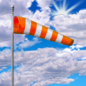

In [48]:
im1

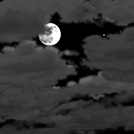

In [49]:
im2

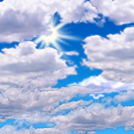

In [50]:
im3

In [51]:
im4

'nothing here yet'